<center><h1>Projet Robotique</h1></center>
<center><h2>Classification via le gradient boosting</h2></center>

# Importation des librairies

In [ ]:
!pip install bayesian-optimization

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

from sklearn.ensemble import AdaBoostClassifier as AdaBoost
from xgboost import XGBClassifier as XGBoost
from catboost import CatBoostClassifier as CatBoost

from bayes_opt import BayesianOptimization

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# Importation du dataset

In [2]:
df = pd.read_csv('preprocessed_data.csv')

df

,MILLISEC,Accelerometer RKN^ accX,Accelerometer RKN^ accY,Accelerometer RKN^ accZ,Accelerometer HIP accX,Accelerometer HIP accY,Accelerometer HIP accZ,Accelerometer LUA^ accX,Accelerometer LUA^ accY,Accelerometer LUA^ accZ,...,LOCATION TAG4 X,LOCATION TAG4 Y,LOCATION TAG4 Z,Locomotion,HL_Activity,LL_Left_Arm,LL_Left_Arm_Object,LL_Right_Arm,LL_Right_Arm_Object,ML_Both_Arms
0,-1.585284,0.146747,0.337532,-1.410530,0.693260,0.434434,0.074936,-0.199117,0.621667,-0.455638,...,0.147947,0.811792,0.186199,0,0,0,0,0,0,0
1,-1.585185,0.263802,0.342378,-1.626921,0.626338,0.487110,0.200034,-0.108635,0.598101,-0.542260,...,0.147947,0.812691,0.178270,0,0,0,0,0,0,0
2,-1.585083,0.194202,0.371457,-1.735116,0.470187,0.527630,0.179184,-0.099275,0.709202,-0.572130,...,0.147947,0.814490,0.172322,0,0,0,0,0,0,0
3,-1.584985,0.058164,0.153369,-1.616313,0.618902,0.523578,0.210459,-0.152316,0.729402,-0.593039,...,0.147947,0.816289,0.172322,0,0,0,0,0,0,0
4,-1.584886,0.247984,0.290684,-1.705415,0.570570,0.535734,0.161809,-0.189757,0.709202,-0.634857,...,0.149055,0.818988,0.176287,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606043,1.407215,0.640278,0.298761,-0.141884,0.358651,0.102168,0.787298,0.418657,0.540867,-0.067329,...,0.129671,0.139901,0.208006,0,0,0,0,0,0,0
606044,1.407317,0.437804,0.297145,-0.020960,0.291729,0.102168,0.776873,0.452977,0.483633,-0.195770,...,0.129117,0.138102,0.206023,0,0,0,0,0,0,0
606045,1.407416,0.678242,0.240604,-0.001866,0.143014,0.110272,0.915871,0.393696,0.503833,-0.195770,...,0.129117,0.136303,0.202059,0,0,0,0,0,0,0
606046,1.407514,1.155955,0.159831,-0.046417,0.098399,0.256145,0.780348,0.362495,0.577900,-0.276418,...,0.129671,0.134504,0.200076,0,0,0,0,0,0,0


# Fonctions diverses

## Fonctions de feature selection

In [3]:
def dim_reduction(df, n):
  pca = PCA(n_components=n)
  pca.fit(df)
  reducted_df = pca.fit_transform(df)
  columns_name = ['column'+str(i) for i in range(1, pca.n_components_+1)]
  return pd.DataFrame(reducted_df, columns=columns_name)

In [4]:
def correlation(dataset, cor):
    df = dataset.copy()
    col_corr = set()  # For storing unique value
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > cor: # absolute values to handle positive and negative correlations
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    df.drop(col_corr,axis = 1,inplace = True)
    return df

## Fonction de segmentation du dataset  

In [5]:
def data_segmentation(dataCollection, window_size, label): # segment the data and create a dataset with locomotion classes as labels

    loco_i = dataCollection.columns.get_loc(label)
    #convert the data frame to numpy array
    data = dataCollection.to_numpy()
    #segment the data
    n = len(data)
    X = []
    y = []
    start = 0
    end = 0

    while start + window_size - 1 < n:
        end = start + window_size-1
        if data[start][loco_i] == data[end][loco_i] and data[start][-1] == data[end][-1] : # if the frame contains the same activity and from the file
            X.append(data[start:(end+1),:])
            y.append(data[start][loco_i])
            start += window_size//2 # 50% overlap
        else: # if the frame contains different activities or from different objects, find the next start point
            while start + window_size-1 < n:
                if data[start][loco_i] != data[start+1][loco_i]:
                    break
                start += 1
            start += 1

    return np.asarray(X), np.asarray(y)

# Modèles de Gradient Boosting

## XGBoost

In [6]:
def my_xgb(X_train, y_train):
    # Create a XGBoost classifier
    model = XGBoost(objective='binary:logistic')

    # Train the classifier
    model.fit(X_train, y_train)

    return model

In [7]:
def pipeline_xgboost(method, tresh):
    if method <= 1:
        dataset = dim_reduction(df[df.columns[:-7]], tresh)
    elif method <= 2:
        dataset = correlation(df[df.columns[:-7]], tresh)

    labels = df[df.columns[-7:]]
    dataset = pd.concat([dataset, labels], axis=1)

    X, y = data_segmentation(dataCollection=dataset, window_size=25, label='HL_Activity')
    X_train, X_test, y_train, y_test = train_test_split(X.mean(axis=1), y, test_size=0.2, random_state=42)
    
    model = my_xgb(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [8]:
pbounds = {
    'method': (0, 2),
    'tresh': (0.1, 0.99),
    }


optimizer = BayesianOptimization(
    f=pipeline_xgboost,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

optimizer.maximize(init_points=10, n_iter=10)
print(optimizer.max)

|   iter    |  target   |  method   |   tresh   |
-------------------------------------------------
| 1         | 1.0       | 0.834     | 0.7411    |
| 2         | 1.0       | 0.0002287 | 0.3691    |
| 3         | 1.0       | 0.2935    | 0.1822    |
| 4         | 1.0       | 0.3725    | 0.4075    |
| 5         | 1.0       | 0.7935    | 0.5795    |
| 6         | 1.0       | 0.8384    | 0.7098    |
| 7         | 1.0       | 0.4089    | 0.8815    |
| 8         | 1.0       | 0.05478   | 0.6967    |
| 9         | 1.0       | 0.8346    | 0.5972    |
| 10        | 1.0       | 0.2808    | 0.2763    |
| 11        | 1.0       | 1.994     | 0.9846    |
| 12        | 1.0       | 1.999     | 0.1307    |
| 13        | 1.0       | 1.998     | 0.1192    |
| 14        | 1.0       | 2.0       | 0.9659    |
| 15        | 1.0       | 1.998     | 0.1082    |
| 16        | 1.0       | 1.999     | 0.9809    |
| 17        | 1.0       | 0.005558  | 0.9739    |
| 18        | 1.0       | 1.997     | 0.1096    |


In [9]:
method = optimizer.max['params']['method']
tresh = optimizer.max['params']['tresh']

if method <= 1:
    dataset = dim_reduction(df[df.columns[:-7]], tresh)
elif method <= 2:
    dataset = correlation(df[df.columns[:-7]], tresh)

labels = df[df.columns[-7:]]
dataset = pd.concat([dataset, labels], axis=1)

X, y = data_segmentation(dataCollection=dataset, window_size=25, label='HL_Activity')

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.mean(axis=1), y, test_size=0.2, random_state=42)

# Create an instance of the Naive Bayes classifier
clf = my_xgb(X_train, y_train)

# Predict the labels for the testing data
y_pred = clf.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


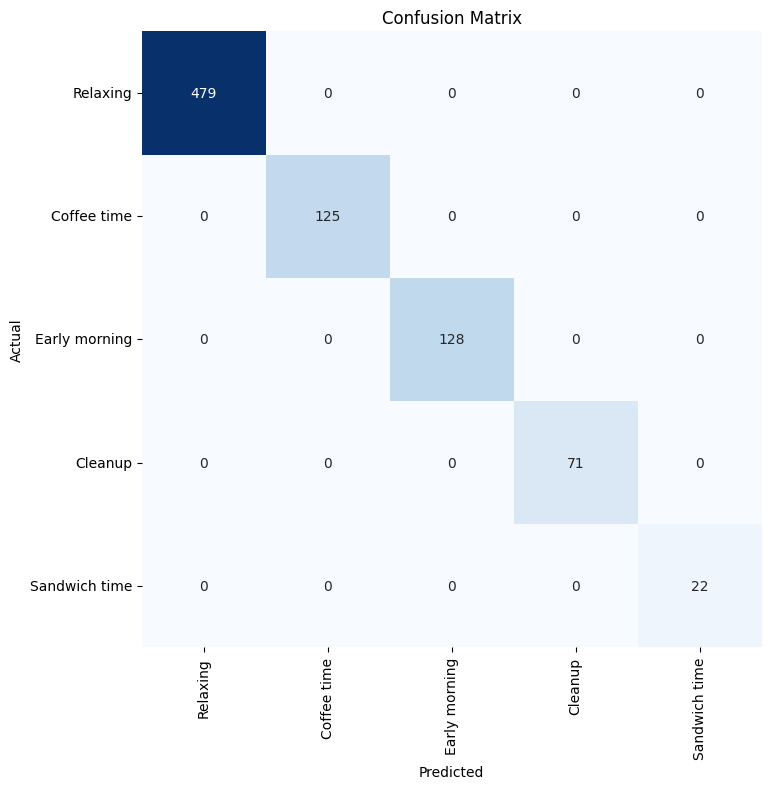

In [10]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=90)
plt.yticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Catboost

In [12]:
def my_catboost(X_train, y_train):
    # Create a CatBoost classifier
    model = CatBoost(verbose=False)

    # Train the classifier
    model.fit(X_train, y_train)

    return model

In [13]:
def pipeline_catboost(method, tresh):
    if method <= 1:
        dataset = dim_reduction(df[df.columns[:-7]], tresh)
    elif method <= 2:
        dataset = correlation(df[df.columns[:-7]], tresh)

    labels = df[df.columns[-7:]]
    dataset = pd.concat([dataset, labels], axis=1)

    X, y = data_segmentation(dataCollection=dataset, window_size=25, label='HL_Activity')
    X_train, X_test, y_train, y_test = train_test_split(X.mean(axis=1), y, test_size=0.2, random_state=42)
    
    model = my_catboost(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [14]:
pbounds = {
    'method': (0, 2),
    'tresh': (0.1, 0.99),
    }


optimizer = BayesianOptimization(
    f=pipeline_catboost,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

optimizer.maximize(init_points=10, n_iter=10)
print(optimizer.max)

|   iter    |  target   |  method   |   tresh   |
-------------------------------------------------
| 1         | 1.0       | 0.834     | 0.7411    |
| 2         | 1.0       | 0.0002287 | 0.3691    |
| 3         | 1.0       | 0.2935    | 0.1822    |
| 4         | 1.0       | 0.3725    | 0.4075    |
| 5         | 1.0       | 0.7935    | 0.5795    |
| 6         | 1.0       | 0.8384    | 0.7098    |
| 7         | 1.0       | 0.4089    | 0.8815    |
| 8         | 1.0       | 0.05478   | 0.6967    |
| 9         | 1.0       | 0.8346    | 0.5972    |
| 10        | 1.0       | 0.2808    | 0.2763    |
| 11        | 1.0       | 1.994     | 0.9846    |
| 12        | 1.0       | 1.999     | 0.1307    |
| 13        | 1.0       | 1.998     | 0.1192    |
| 14        | 1.0       | 2.0       | 0.9659    |
| 15        | 1.0       | 1.998     | 0.1082    |
| 16        | 1.0       | 1.999     | 0.9809    |
| 17        | 1.0       | 0.005558  | 0.9739    |
| 18        | 1.0       | 1.997     | 0.1096    |


In [15]:
method = optimizer.max['params']['method']
tresh = optimizer.max['params']['tresh']

if method <= 1:
    dataset = dim_reduction(df[df.columns[:-7]], tresh)
elif method <= 2:
    dataset = correlation(df[df.columns[:-7]], tresh)

labels = df[df.columns[-7:]]
dataset = pd.concat([dataset, labels], axis=1)

X, y = data_segmentation(dataCollection=dataset, window_size=25, label='HL_Activity')

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.mean(axis=1), y, test_size=0.2, random_state=42)

# Create an instance of the Naive Bayes classifier
clf = my_catboost(X_train, y_train)

# Predict the labels for the testing data
y_pred = clf.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


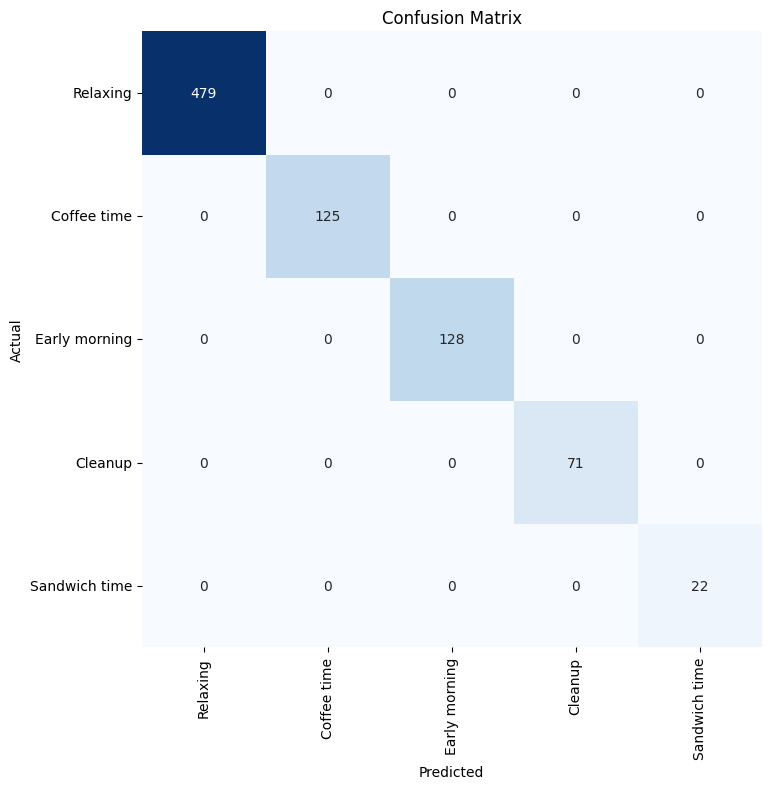

In [16]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=90)
plt.yticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()